<!--
IRdisplay::display_html(file='code_hiding.html')
if the line above generates an error, it could be due to this:
https://github.com/IRkernel/IRdisplay/issues/41
In the meantime, the code below is enough; it works on nbviewer but not on the notebook directly
-->
<script>
  code_show=true;
  function code_toggle() {
    if (code_show){
      $('div.input').hide();
    } else {
      $('div.input').show();
    }
    code_show = !code_show
  } 
  $( document ).ready(code_toggle);
</script>
<font size=4>
<a href="javascript:code_toggle()">Toggle ON/OFF</a>
code cells.
</font>

**Author**: Adrian Ernesto Radillo  
**Date**: 06 Apr 2019
### LINKS TO MAIN SECTIONS
[Introduction](#intro)  
[Data pre-processing](#preproc)  
[Timing and trials checks](#checks)  
[Accuracy analysis](#acc)  
[Dot count in hemifields](#dotcount)  
[Autocorrelation of choices](#autocorr)  

# Introduction
<a id='intro'></a>
## Release notes

- For the first time I join data from 2 subjects. 
- First time also, I stop dumping dots and frames info.

## A word on the data for this notebook
The tags for this data are `Pilot 13` and `Pilot 14`. It was collected in the psychophysics booth with these codes: [Pilot 13](https://github.com/TheGoldLab/SingleCP_DotsReversal_Task/releases/tag/pilot13_mat), 
[Pilot 14](https://github.com/TheGoldLab/SingleCP_DotsReversal_Task/releases/tag/pilot14_mat).

## Feedback from subjects
- Pauses are much needed. Self-pacing might not be enough (or maybe was poorly instructed).
- Head rest should be cleaned before the experiment.
- Getting comfy in front of the screen is not so easy to achieve. Frequent pauses and responding with gaze (instead of keyboard) should help with this.

## Data analysis workflow description
1. Task is run with repo [SingleCP_DotsReversal_Task](https://github.com/TheGoldLab/SingleCP_DotsReversal_Task/) (for this dataset, the branch `psychophys_tests` was used).
  1. A `.mat` data file is outputted for each subject (here, `2019_04_04_XX_XX_topsDataLog.mat`); in addition, I manually copy all the output from the MATLAB console into a text file (here, `consoleDump_2019_04_04_XX_XX.log`)
  2. These data files are tracked with `git-lfs` in the task repo mentioned above.
2. Data is analyzed with repo [SingleCP_DotsReversal_DataAnalaysis](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis)(again, with the appropriate branch -- currently `logistic_fits`).
  1. The first step is to convert data from the .mat file into CSV format with [this script](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis/blob/05d405594b1908ea9854d155617b038ac47356af/MATLAB_scripts/mat2csv.m) 
    - `pilot#_FIRA.csv`  [Fields description](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis/wiki/Fields-Description-of-*FIRA.csv-files).


## Unordered Q&A
**Q:** Plot indep var. as fcn of trial count, to ensure real randomization was implemented by the task algorithm.  
**A:** Things look fine [here](#randIndVar).
    
**Q:** Why [this pattern of errors](#errorsVD) in `(dotsOff-dotsOn) - viewingDuration`?  
**A: Unanswered**  


**Q:** Do subjects display a tendency to repeat the answer from the last trial?  
**A:** Can [autocorrelation](#autocorr) tell us something?  

In [1]:
# load packages 

# Note:
# if one of the packages below is not installed, type, once, in another cell
# install.packages("<package_name>", lib="<path_to_installation_folder>")
# note that if you don't put the lib arg above, it will default to first item in .libPaths()
# ref:https://www.rdocumentation.org/packages/utils/versions/3.5.2/topics/install.packages

# I can't load the conflicted package here :(
# library(conflicted)
# https://github.com/r-lib/conflicted/issues/26

library(data.table)     # see https://cran.r-project.org/web/packages/data.table/vignettes/datatable-intro.html for reference
library(ggplot2)        # for plots
library(repr)           # for resizing figures
library(OneR)           # to use the function 'bin'
library(gridExtra)      # to use grid.arrange()

source("../R_functions.r") # custom functions

In [2]:
# DEFINE CONSTANTS
# folder/file-specific constants
PILOT_NUMBERS <- list(13, 14)
PILOT_NUMBER <- paste(PILOT_NUMBERS, collapse = '-')

DATA_FOLDER <- "../../data/"
FIRA_TAG <- "FIRA"

# data-related constants
FIRST_TRIALS_TO_DISCARD <- 1

# plot-specific constants
PLOT_TITLE_FONT_SIZE <- 18
PLOT_SUBTITLE_FONT_SIZE <- 13 
AXES_LABEL_FONT <- 14
AXES_FONT <- 13

ERROR_WIDTH <- 4
SMALL_ERROR_WIDTH <- .01*ERROR_WIDTH

LINE_WIDTH <- 1.4
POINT_SIZE <- 2
SMALL_DOT_SIZE <- 1

# other variables
FRAME_RATE_ESTIMATE <- 60 # Hz
FRAME_DURATION <- (1 / FRAME_RATE_ESTIMATE) # sec

In [3]:
# load csv files into data.tables
TRIALS <- loadMultiplePilotCSV(PILOT_NUMBERS, DATA_FOLDER, FIRA_TAG)

In [4]:
NODES = unique(TRIALS[,taskID])
NUM_NODES = length(NODES)

In [5]:
NUM_SUBJECTS <- length(PILOT_NUMBERS)

# Data pre-processing
<a id='preproc'></a>
## Summary of `TRIALS` dataset (`*FIRA.csv` file)

In [6]:
# set some variables to "factor"
TRIALS[,`:=`(choice=as.factor(choice), 
            correct=as.logical(correct), # probably a bad idea to have this be a factor variable
            initDirection=as.factor(initDirection),
            endDirection=as.factor(endDirection),
            presenceCP=as.logical(presenceCP))]
# put back in missing values
TRIALS[choice == 'NaN' | correct == 'NaN', `:=`(choice = NA, correct = NA)] 

# display summary for reference
str(TRIALS)

Classes ‘data.table’ and 'data.frame':	1055 obs. of  25 variables:
 $ taskID         : int  1 1 1 1 1 1 1 1 1 1 ...
 $ trialIndex     : int  68 39 28 69 47 17 32 31 89 36 ...
 $ trialStart     : num  1364115 1364120 1364125 1364128 1364132 ...
 $ trialEnd       : num  1364120 1364125 1364128 1364132 1364135 ...
 $ RT             : num  0.577 0.637 0.556 0.853 0.363 ...
 $ choice         : Factor w/ 3 levels "0","1","NaN": 1 1 1 1 2 1 1 2 2 1 ...
 $ correct        : logi  TRUE FALSE TRUE FALSE TRUE FALSE ...
 $ initDirection  : Factor w/ 2 levels "0","180": 2 1 2 1 1 1 2 1 1 2 ...
 $ endDirection   : Factor w/ 2 levels "0","180": 2 1 2 1 1 1 2 1 1 2 ...
 $ presenceCP     : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ coherence      : num  24 21 40 39 50 50 57 57 56 56 ...
 $ viewingDuration: num  0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 ...
 $ probCP         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ timeCP         : num  0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 ...
 $ randSeedBase   : int  75

## Classify trials
We classify trials as follows:
- `valid` means that the trial is kept in the analysis
- `skipped` means that no answer was recorded (this could be linked to fixation break for instance)
- `bug` means the code itself renders the trial unusable (for instance the 1st trial, because of our timing bug)
- `early` means that an answer was provided before the end of the viewing duration

Currently, I don't control for the fact that a single trial might fall into more than one non-valid category. I just make sure all `valid` trials are indeed valid.

In [7]:
setkey(TRIALS, 'trialStart')
for (subject in PILOT_NUMBERS) {
    for (node in NODES) {
        TRIALS[pilotID==subject & taskID==node, trialInSession:=.I]
    }
}

TRIALS[,`:=`(trialClass='valid')]

In [8]:
TRIALS[is.na(choice), trialClass:='skipped']
TRIALS[trialInSession <= FIRST_TRIALS_TO_DISCARD, trialClass:='bug']
TRIALS[RT <= 0, trialClass:='early']
TRIALS[,trialClass:=as.factor(trialClass)]

In [9]:
mytheme <- theme(
    plot.title=element_text(size=PLOT_TITLE_FONT_SIZE, lineheight=1.2),  # title
    plot.subtitle=element_text(size=PLOT_SUBTITLE_FONT_SIZE),            # subtitle
    plot.caption=element_text(size=PLOT_SUBTITLE_FONT_SIZE),             # caption
    axis.title.x=element_text(size=AXES_LABEL_FONT),                     # X axis title
    axis.title.y=element_text(size=AXES_LABEL_FONT),                     # Y axis title
    axis.text.x=element_text(size=AXES_FONT),                            # X axis text
    axis.text.y=element_text(size=AXES_FONT)                             # Y axis text
    )

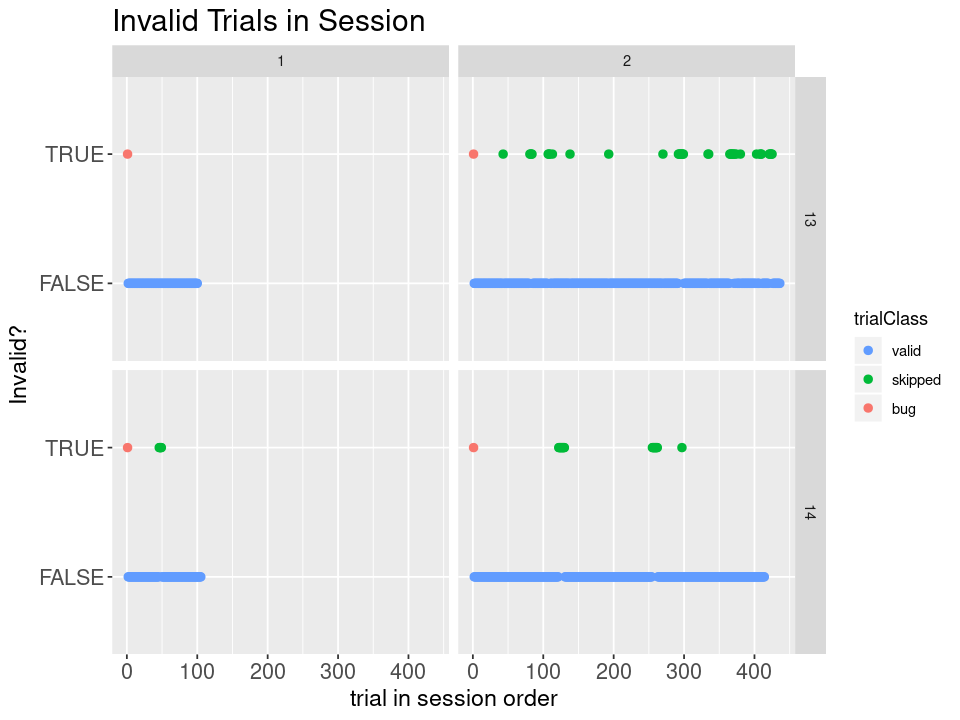

In [10]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=6)

ggplot(TRIALS, aes(x=trialInSession, y=trialClass != 'valid')) + 
    geom_point(aes(col=trialClass), size=POINT_SIZE) +
    facet_grid(pilotID ~ taskID) + 
    labs(title="Invalid Trials in Session", x="trial in session order", y="Invalid?") +
    mytheme +
    guides(colour = guide_legend(reverse=T))

## Match trials across datasets

How many trials were produced in each dataset?

In [11]:
TRIALS[, .(num_trials=.N, num_valid_trials=sum(trialClass=='valid')), by=.(taskID, pilotID)]
# nrow is inefficient compared to .N
#the following URL are enlightening
#https://cran.r-project.org/web/packages/data.table/vignettes/datatable-intro.html

taskID,pilotID,num_trials,num_valid_trials
1,13,100,99
2,13,436,395
1,14,105,100
2,14,414,395


Let's introduce a `validTrialCount` column in all datasets, with invalid trials flagged `validTrialCount=NA_integer_`.

In [12]:
for (node in NODES) {    
    for (subj in PILOT_NUMBERS) {
        TRIALS[trialClass == 'valid' & taskID==node & pilotID==subj, validTrialCount:=.I]
    }
}

In [13]:
TRIALS[trialClass != 'valid', validTrialCount := NA_integer_]

# Timing and trial checks
<a id='checks'></a>
How long did the session last?

In [14]:
for (node in NODES) {
    for (subj in PILOT_NUMBERS) {
        cat('Task', node, ' for subject', subj, 'lasted', round(TRIALS[pilotID==subj & taskID==node,sum(trialEnd - trialStart)] / 60, digits = 2), "min.\n" )
    }
}

Task 1  for subject 13 lasted 6.68 min.
Task 1  for subject 14 lasted 6.72 min.
Task 2  for subject 13 lasted 31.02 min.
Task 2  for subject 14 lasted 27.09 min.


<!-- this is not so important anymore.
Were some trials presented again after failure? -->

- How many trials were produced per combination of factors? **(TODO: any better way of displaying these results?)**

In [15]:
print("How can I better visualize this?")
indepVarNames <- c("initDirection","presenceCP","coherence","viewingDuration","probCP","timeCP")
for (node in NODES) {
    for (subj in PILOT_NUMBERS) {
        cat('\n\n===========================\n TASK', node, 'SUBJECT', subj, '\n\n\n')
        combFactors <- getFreq(TRIALS[pilotID==subj & taskID==node & !is.na(validTrialCount)], indepVarNames)
        print(combFactors)
    }
}

[1] "How can I better visualize this?"


 TASK 1 SUBJECT 13 


    initDirection presenceCP coherence viewingDuration probCP timeCP numTrials
 1:             0      FALSE        21             0.2      0    0.2         1
 2:           180      FALSE        40             0.2      0    0.2         1
 3:             0      FALSE        39             0.2      0    0.2         1
 4:             0      FALSE        50             0.2      0    0.2         3
 5:           180      FALSE        57             0.2      0    0.2         7
 6:             0      FALSE        57             0.2      0    0.2         3
 7:             0      FALSE        56             0.2      0    0.2         6
 8:           180      FALSE        56             0.2      0    0.2         5
 9:           180      FALSE        55             0.2      0    0.2         3
10:             0      FALSE        55             0.2      0    0.2         5
11:           180      FALSE        54             0.2      0    0.2

- What were the marginal frequencies? **(TODO:improve visualization)**

In [16]:
# print("visualization pending")
for (node in NODES) {
    for (subj in PILOT_NUMBERS) {
        cat('\n\n===========================\n TASK', node, 'SUBJECT', subj, '\n\n\n')
        for (i in 1:length(indepVarNames)) {
            print(getFreq(TRIALS[pilotID==subj & taskID==node & !is.na(validTrialCount)], indepVarNames[i]))
        }
    }
}



 TASK 1 SUBJECT 13 


   initDirection numTrials percent
1:             0        50      50
2:           180        49      49
   presenceCP numTrials percent
1:      FALSE        99     100
    coherence numTrials percent
 1:        21         1       1
 2:        40         1       1
 3:        39         1       1
 4:        50         7       7
 5:        57        10      10
 6:        56        11      11
 7:        55         8       8
 8:        54         6       6
 9:        58         9       9
10:        59         3       3
11:        53         5       5
12:        52         4       4
13:        51         5       5
14:        49        12      12
15:        48        13      13
16:        47         3       3
   viewingDuration numTrials percent
1:             0.2        99     100
   probCP numTrials percent
1:      0        99     100
   timeCP numTrials percent
1:    0.2        99     100


 TASK 1 SUBJECT 14 


   initDirection numTrials percent
1:             0  

## Random indep vars.
<a id='randIndVar'></a>
We now plot the independent variables as a function of trial number in the task, to check randomization (at least eye-balling).

task 1 subject 13task 2 subject 13

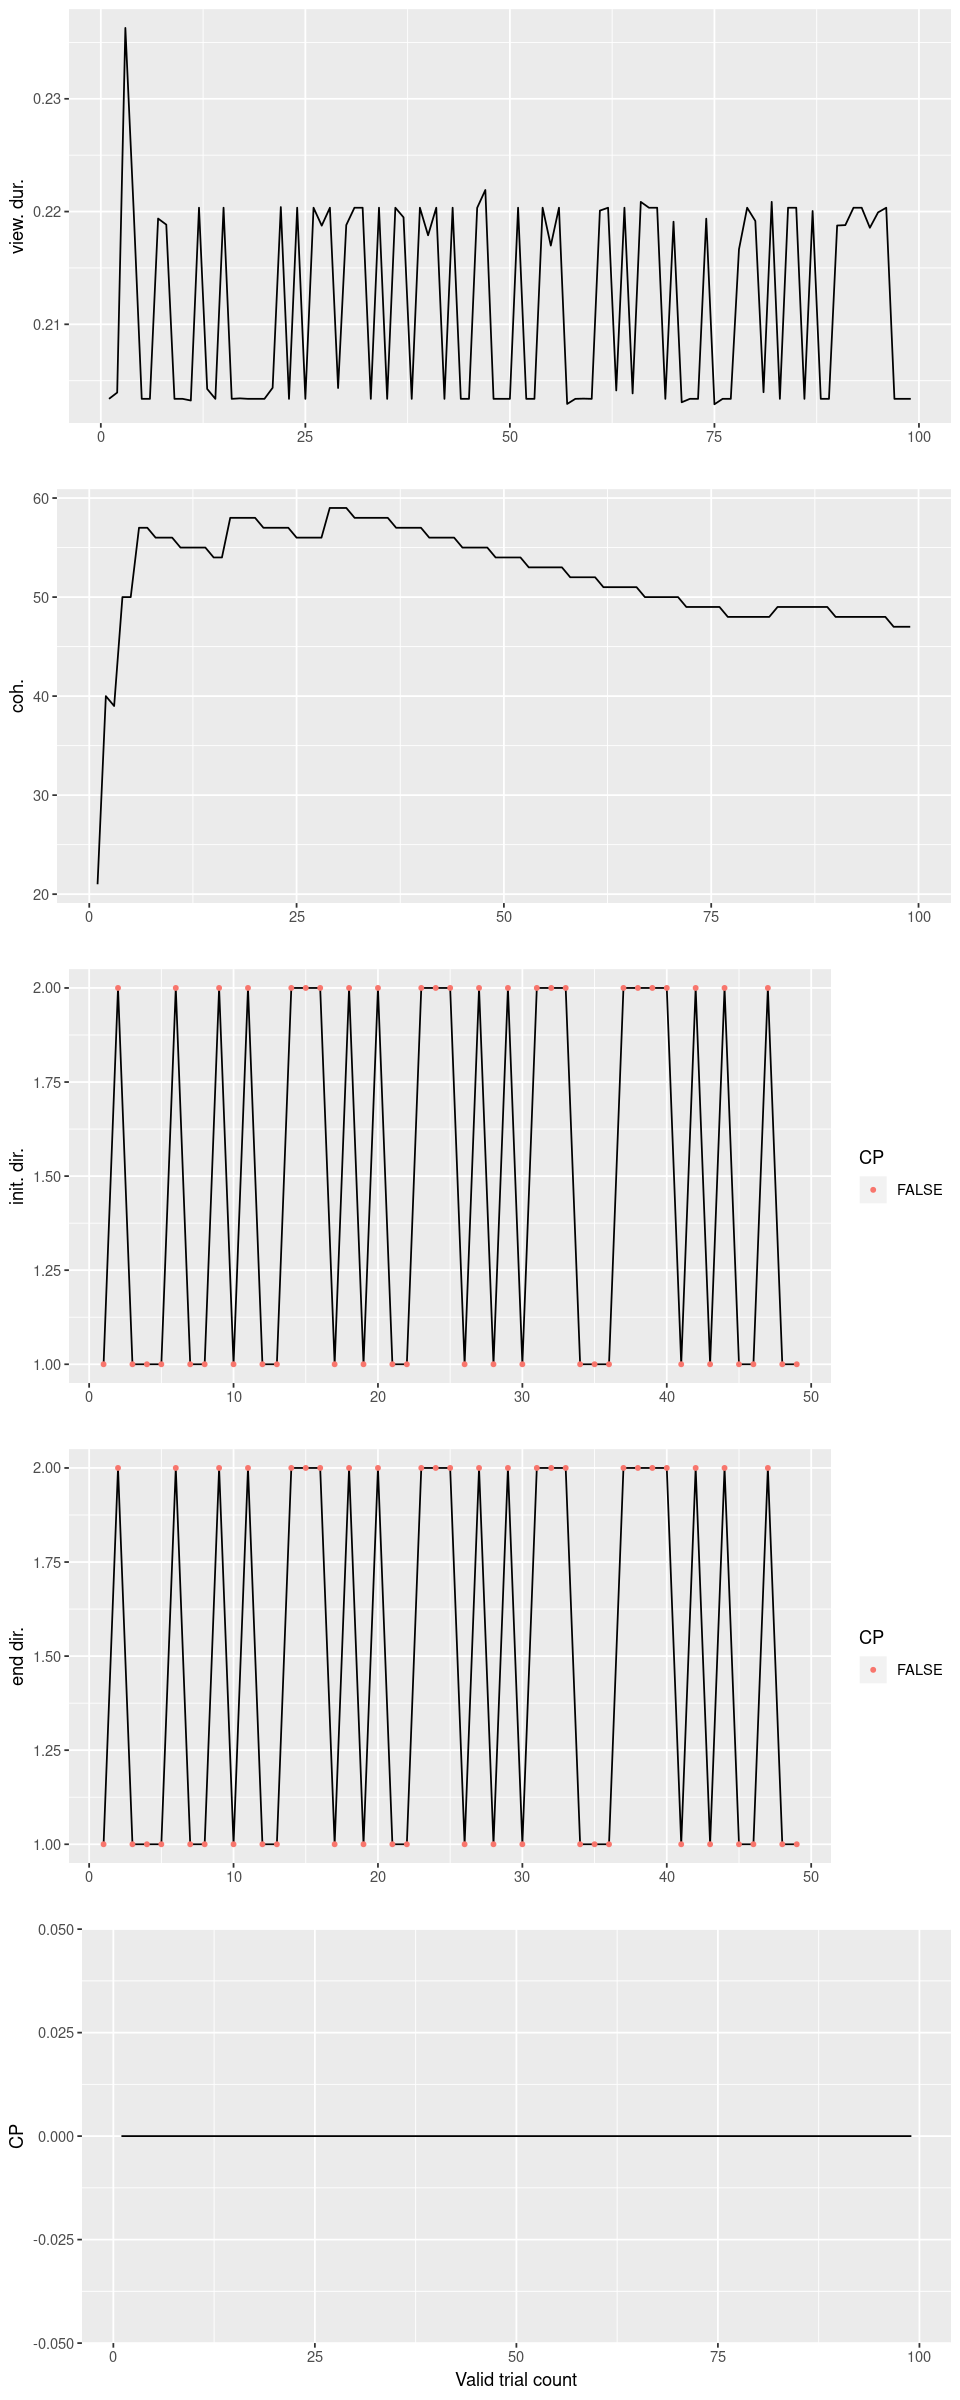

task 1 subject 14

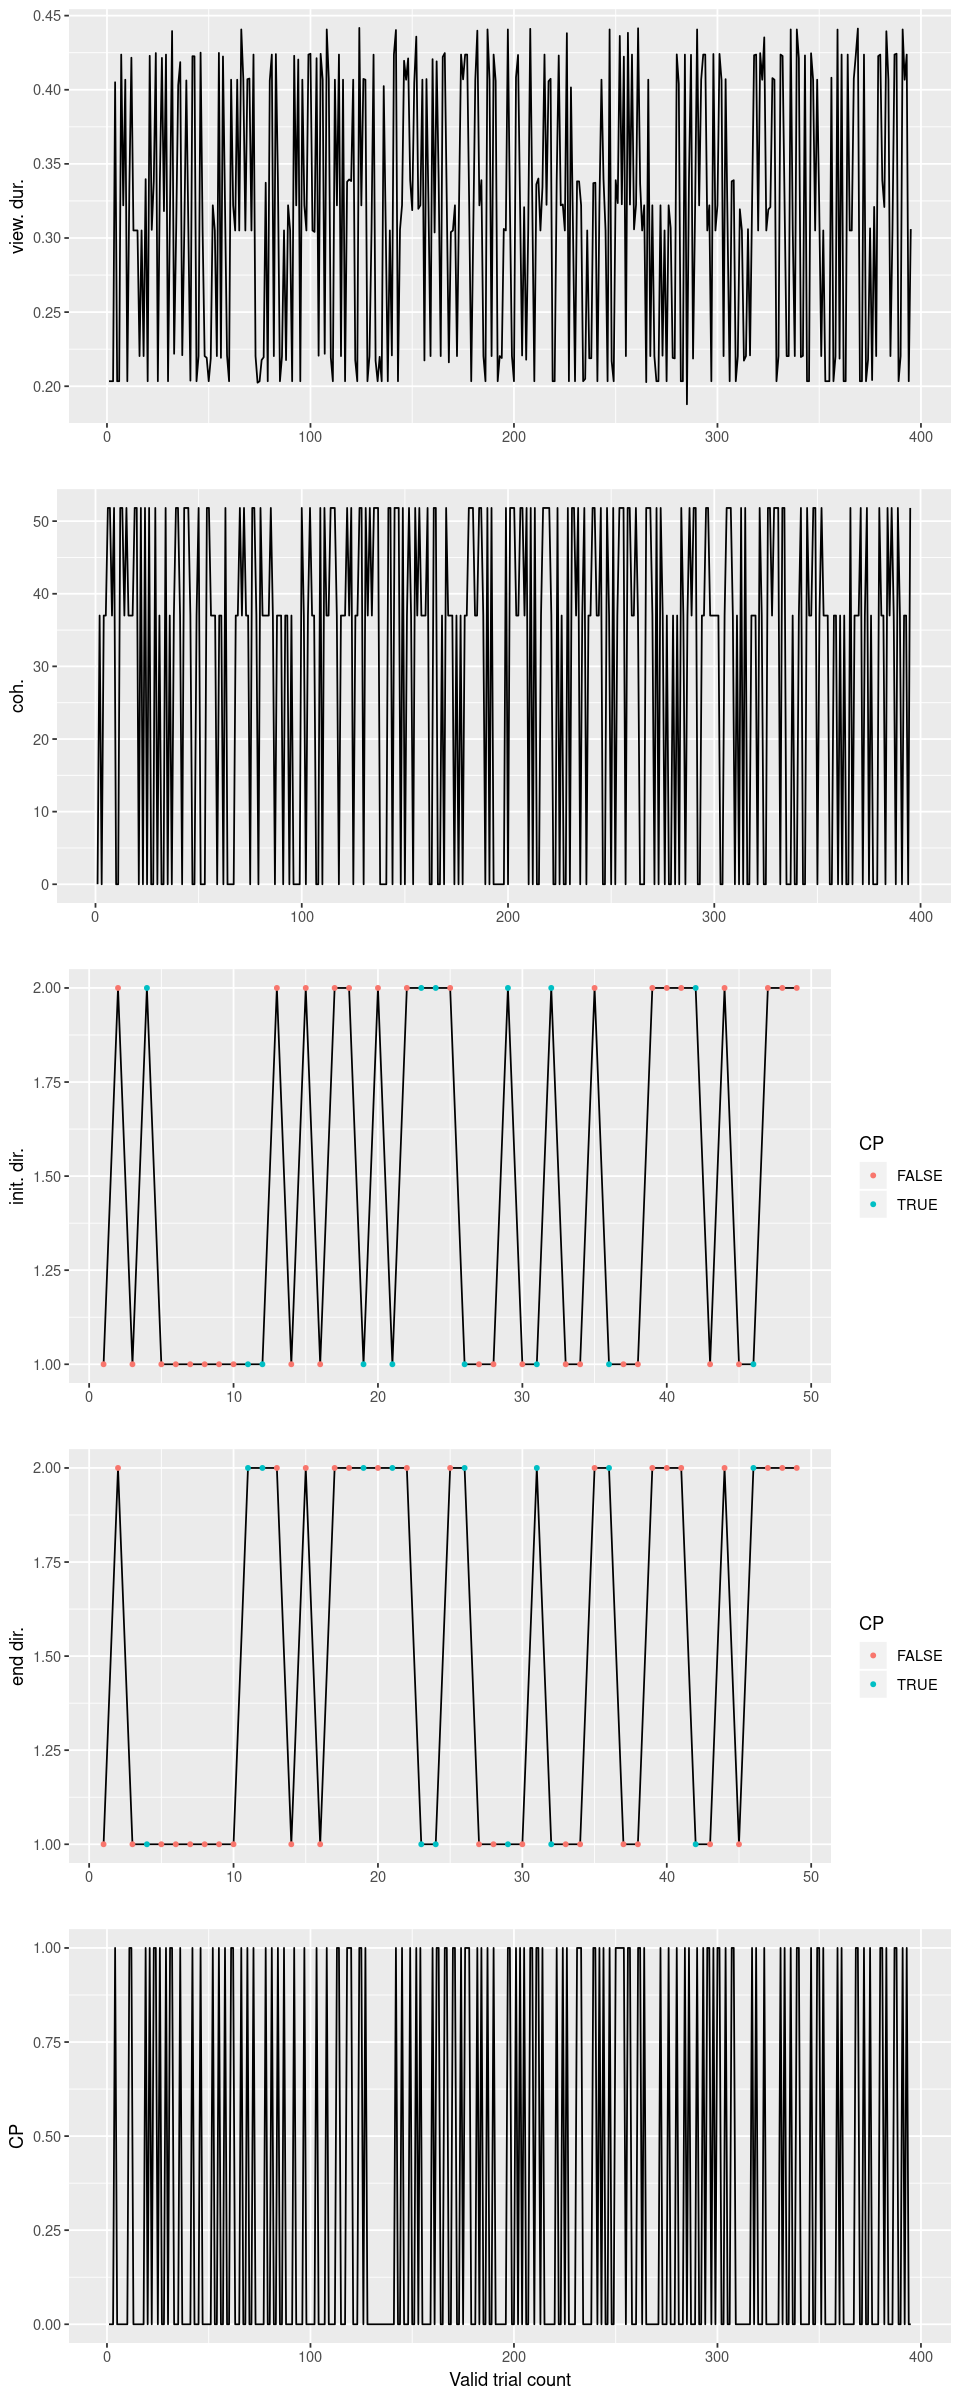

task 2 subject 14

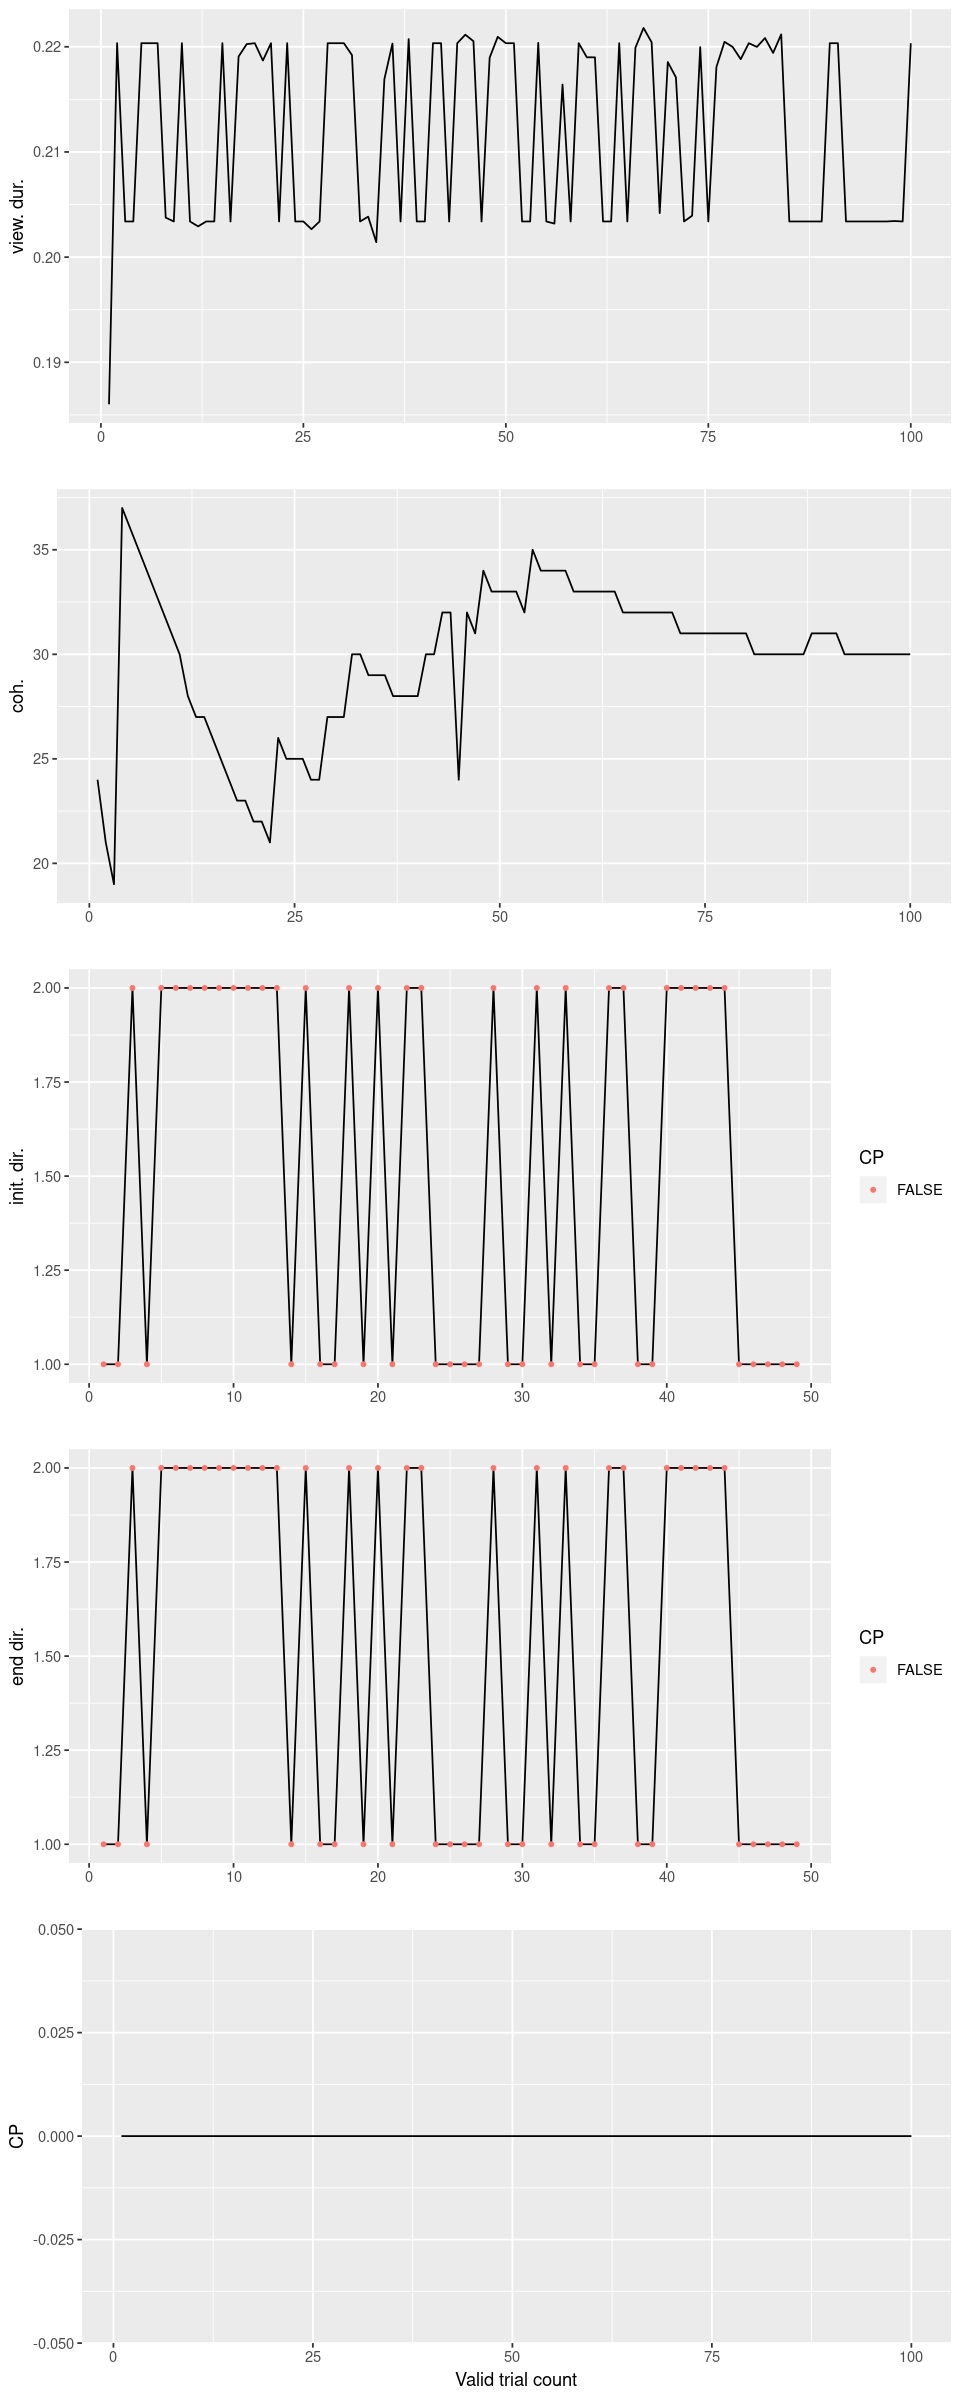

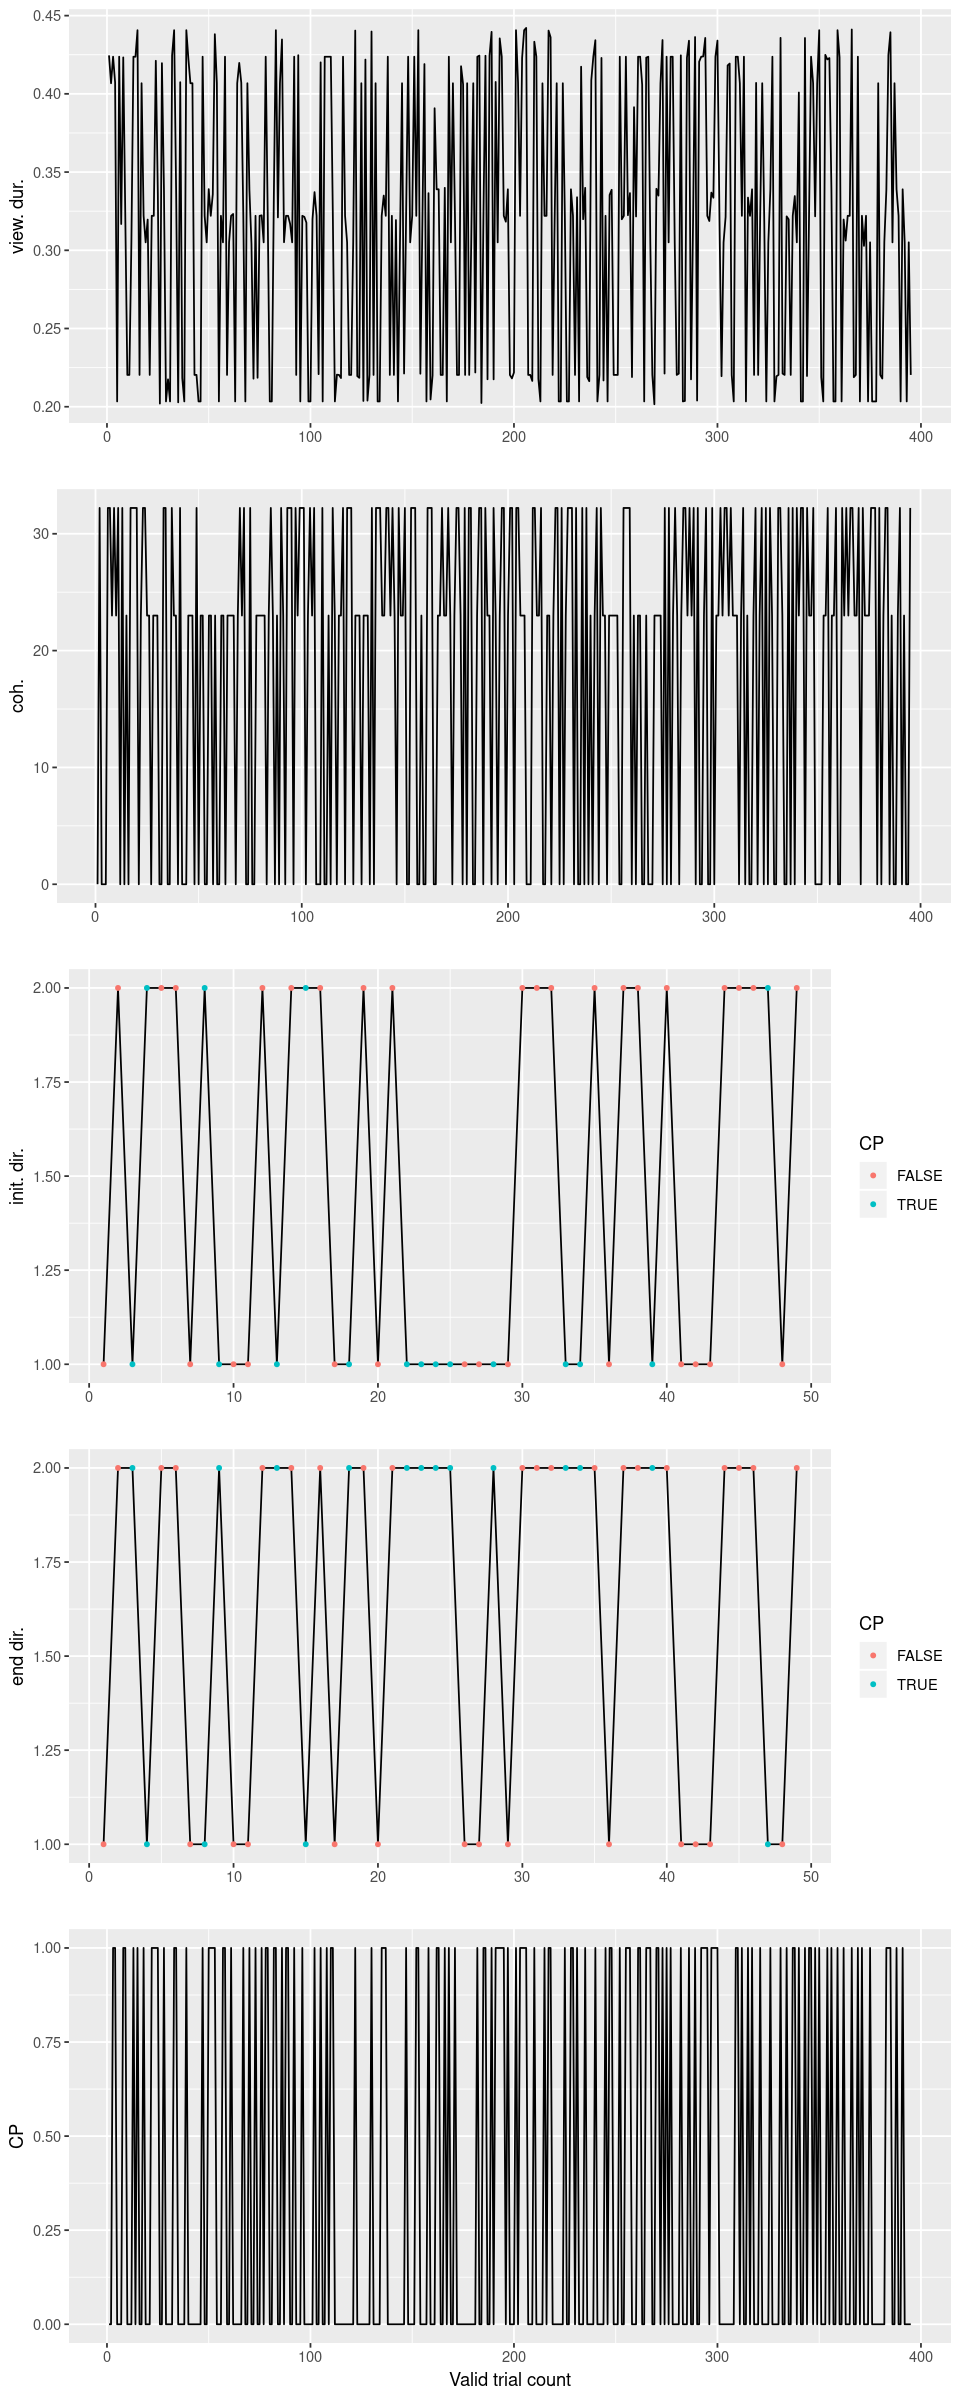

In [18]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=20)
for (subj in PILOT_NUMBERS) {
    for (node in NODES) {
        p1 <- ggplot(TRIALS[pilotID==subj & taskID==node & !is.na(validTrialCount)], 
                     aes(x=validTrialCount, y=dotsOff - dotsOn)) + 
            geom_line() +
            labs(x="", y="view. dur.", title=cat('task', node, 'subject', subj))


        p2 <- ggplot(TRIALS[pilotID==subj & taskID==node & !is.na(validTrialCount)], aes(x=validTrialCount, y=coherence)) +
            geom_line() +
            labs(x="", y="coh.")


        p3 <- ggplot(TRIALS[pilotID==subj & taskID==node & !is.na(validTrialCount) & validTrialCount < 50], 
                 aes(x=validTrialCount, y=as.numeric(initDirection))) + 
            geom_line() + geom_point(aes(col=presenceCP), size=SMALL_DOT_SIZE) +
            labs(x="", y="init. dir.", colour="CP")


        p4 <- ggplot(TRIALS[pilotID==subj & taskID==node & !is.na(validTrialCount) & validTrialCount < 50], 
                 aes(x=validTrialCount, y=as.numeric(endDirection))) + 
            geom_line() + geom_point(aes(col=presenceCP), size=SMALL_DOT_SIZE) +
            labs(x="", y="end dir.", colour="CP")


        p5 <- ggplot(TRIALS[pilotID==subj & taskID==node & !is.na(validTrialCount)], aes(x=validTrialCount, y=as.numeric(presenceCP))) + 
            geom_line() + 
            labs(x="Valid trial count", y="CP")

        grid.arrange(p1,p2,p3,p4,p5, nrow=5) 
    }
}

## A deeper look at the timestamps fields

Recall that in the plot below, `targetOn` corresponds to the display time of the targets, which requires first the subject to *hold fixation*.

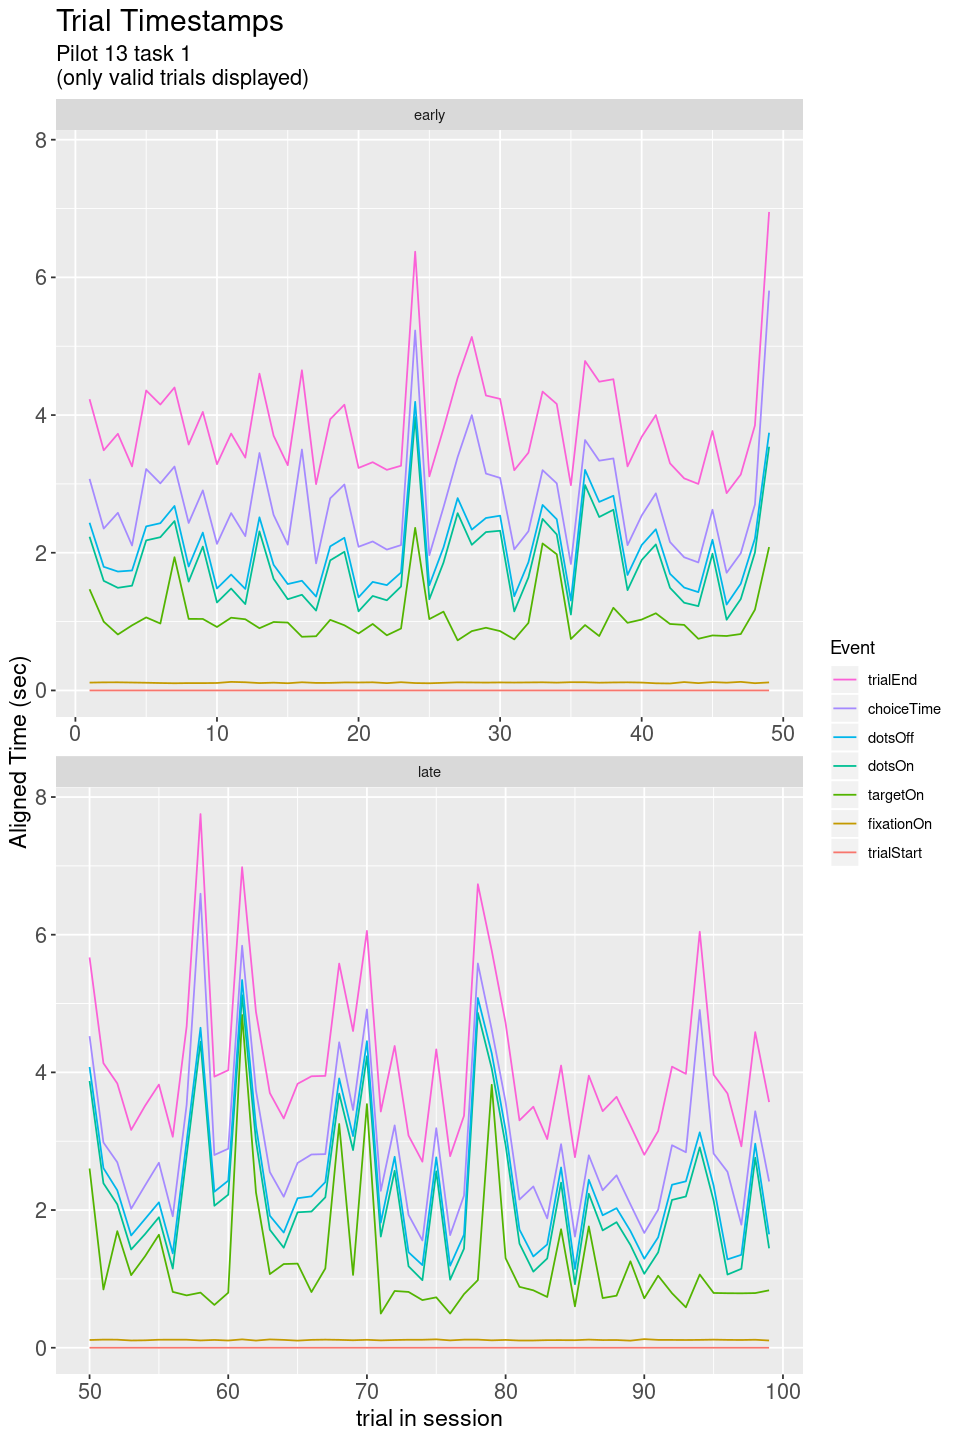

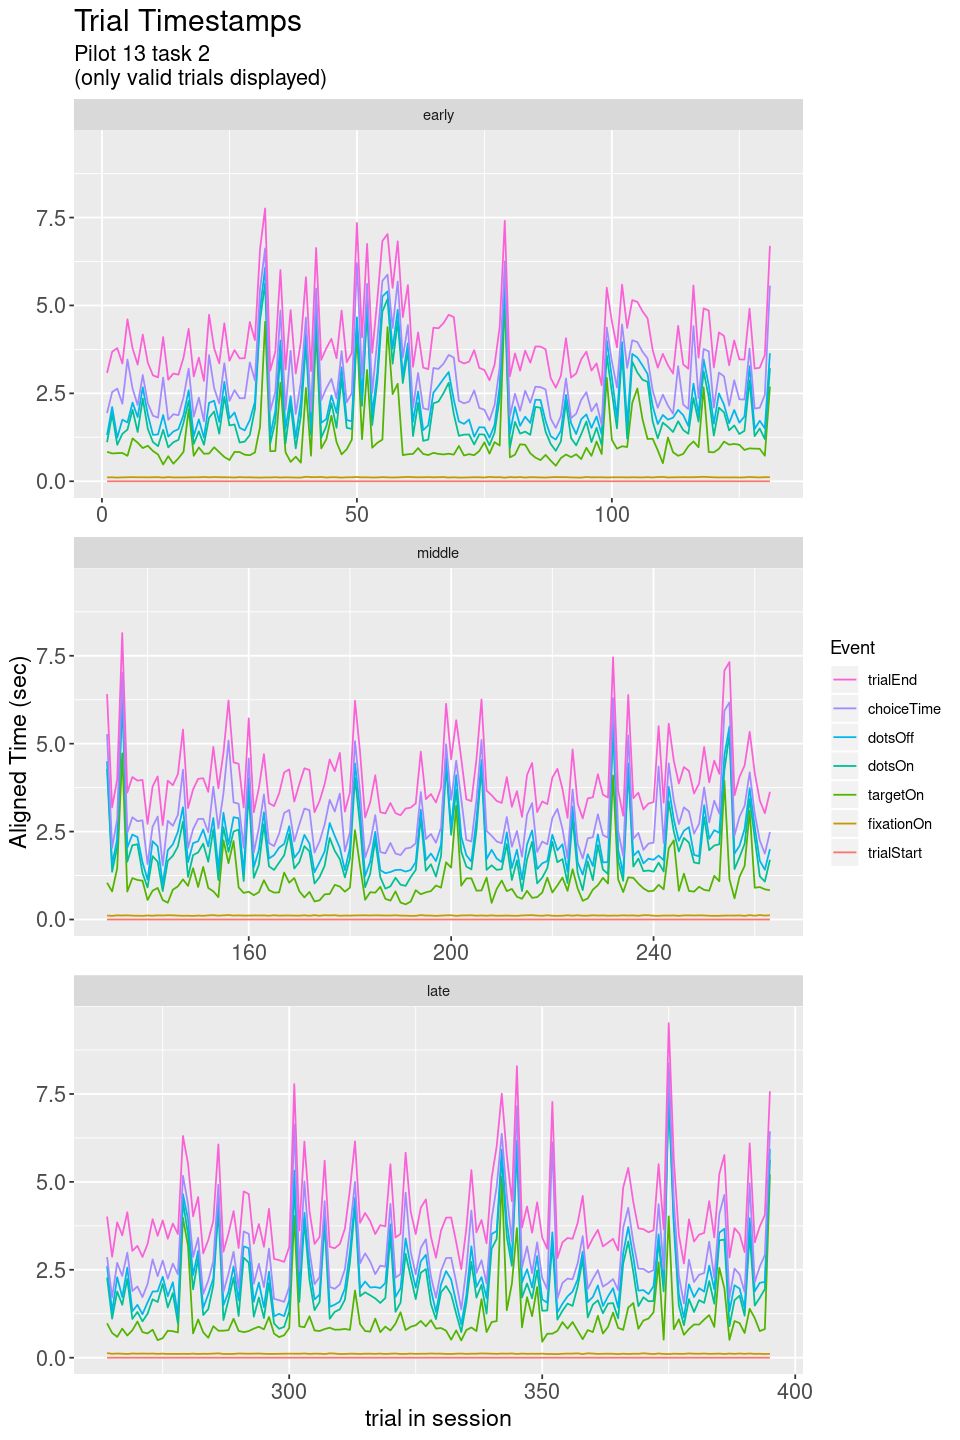

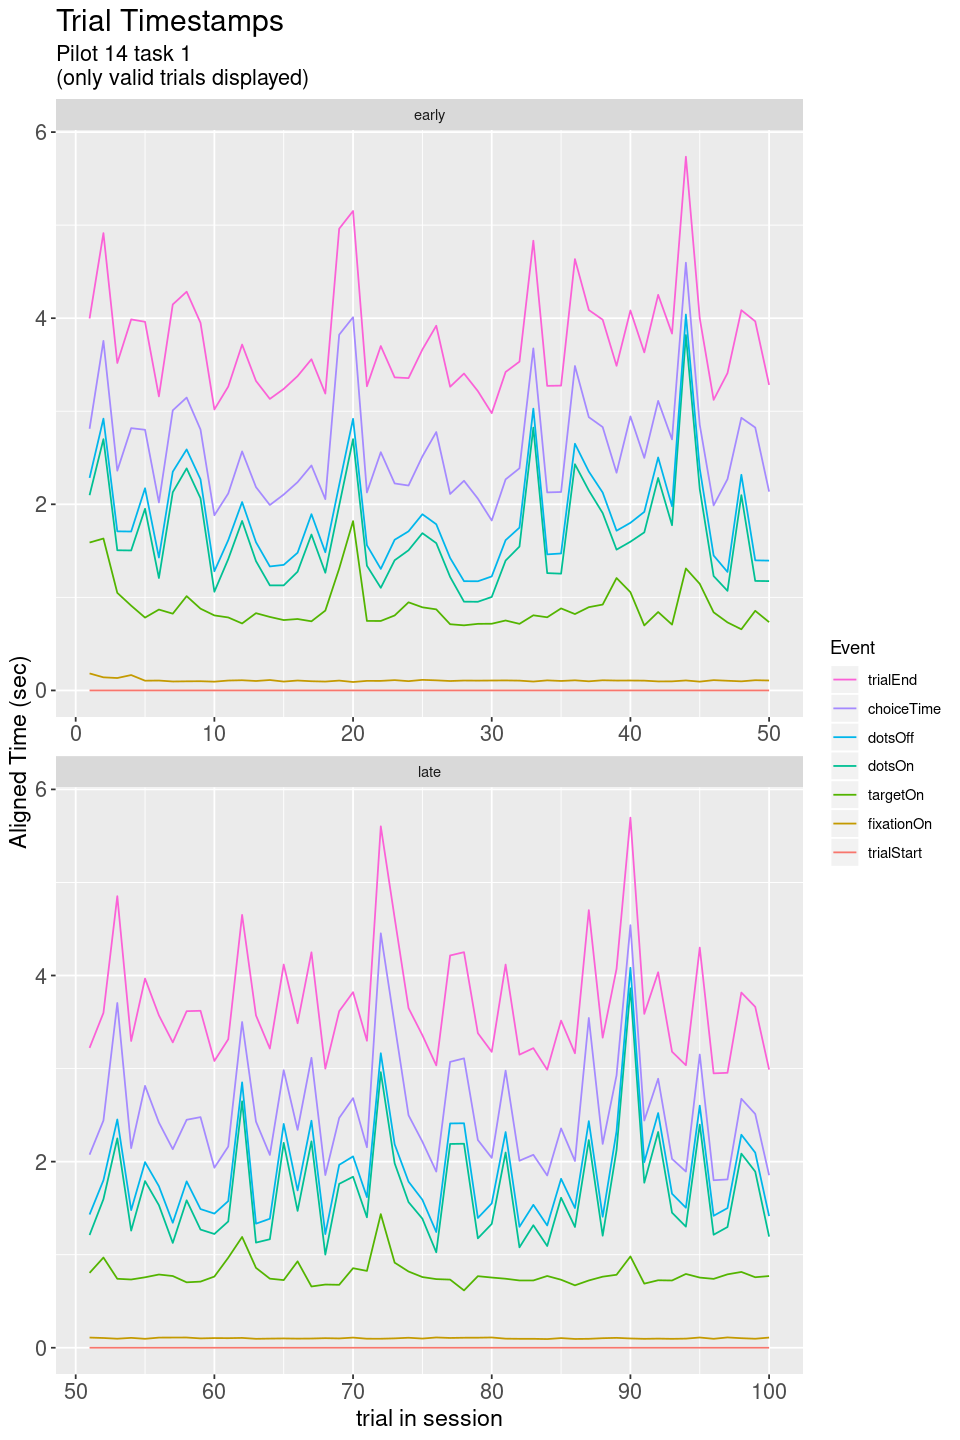

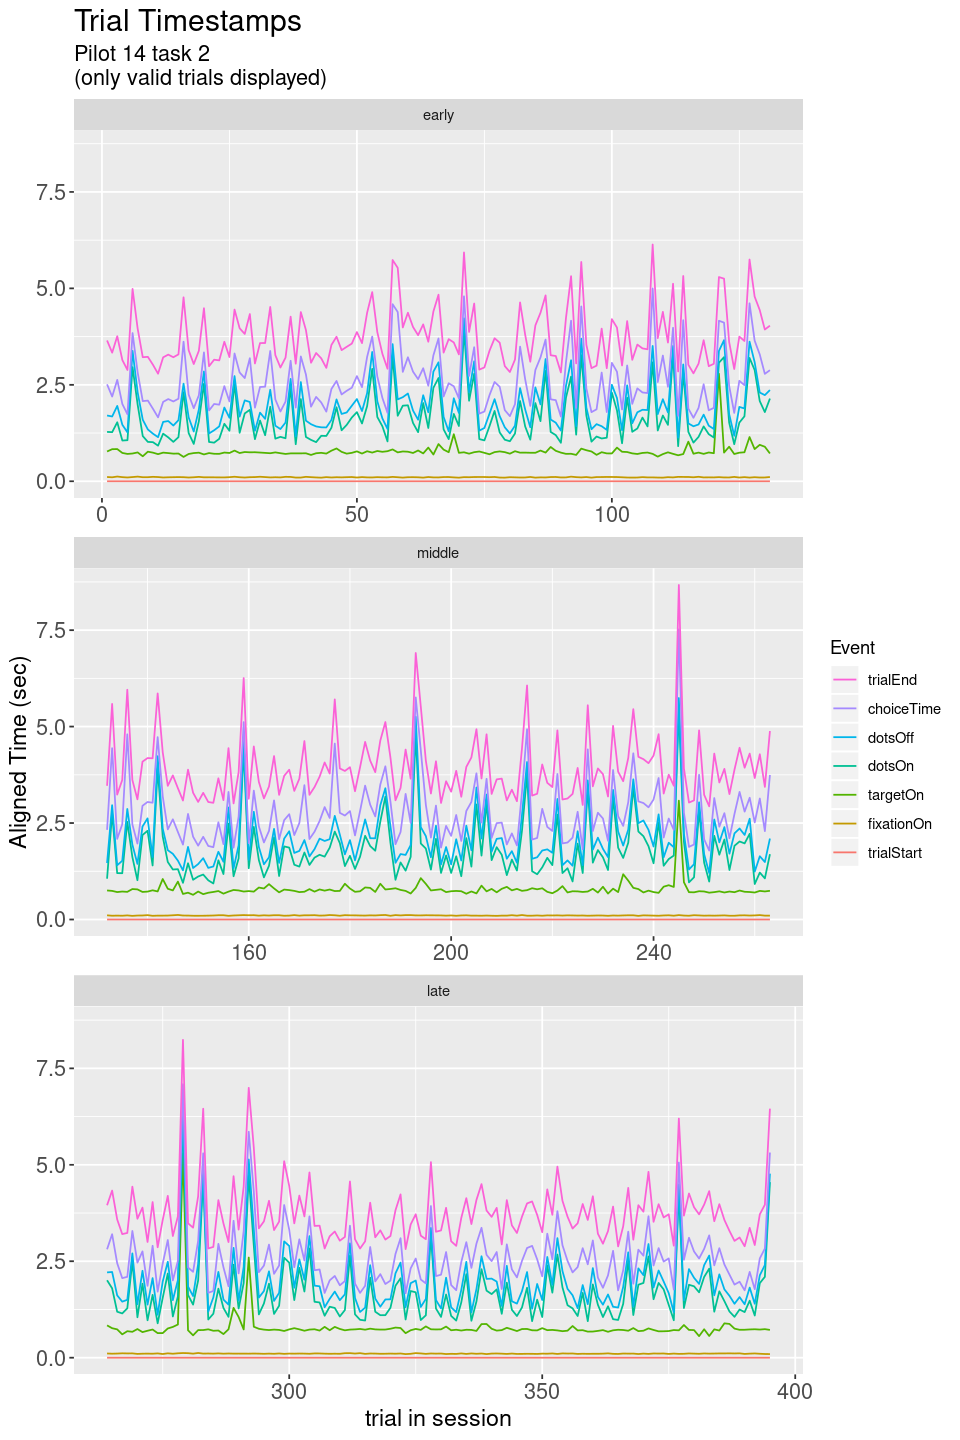

In [44]:
options(repr.plot.width=8, repr.plot.height=12)
for (subj in PILOT_NUMBERS) {
    for (node in NODES) {
        wideTimestamps <- TRIALS[pilotID==subj & taskID==node & !is.na(validTrialCount),
                                 .(trialStart=trialStart-trialStart,
                                   trialEnd=trialEnd-trialStart,
                                   dotsOn,
                                   dotsOff,
                                   nDotsOn=0,
                                   nDotsOff=dotsOff - dotsOn,
                                   targetOn,
                                   fixationOn,
                                   choiceTime,
                                   presenceCP),by=validTrialCount]

        longTimestamps <- melt(wideTimestamps,
                               id.vars=c("validTrialCount"),
                               measure.vars=c("trialStart","fixationOn","targetOn",
                                              "dotsOn","dotsOff",
                                              "choiceTime","trialEnd"),
                               value.name="timestamp", variable.name="Event")

        # since we have many trials, let's split the plots in 3
        longTimestamps[, sessionPeriod:='early']
        if (longTimestamps[,max(validTrialCount)] > 100) {
            longTimestamps[validTrialCount > max(validTrialCount) / 3, sessionPeriod:='middle']
            longTimestamps[validTrialCount > 2 * max(validTrialCount) / 3, sessionPeriod:='late']
            longTimestamps[, sessionPeriod := factor(sessionPeriod, levels=c("early", "middle", "late"))]
        } else {
            longTimestamps[validTrialCount > max(validTrialCount) / 2, sessionPeriod:='late']
            longTimestamps[, sessionPeriod := factor(sessionPeriod, levels=c("early","late"))]
        }
        

        # plot
        ppp <- ggplot(longTimestamps, aes(x=validTrialCount, y=timestamp)) +
           geom_line(aes(col=Event),size=.5) + 
           guides(colour = guide_legend(reverse=T)) +
           facet_wrap(sessionPeriod~.,nrow=length(levels(longTimestamps$sessionPeriod)), scales="free_x")+
           labs(title="Trial Timestamps",
                subtitle=paste("Pilot",subj,"task",node,"\n(only valid trials displayed)",sep=" "),
                y="Aligned Time (sec)", x="trial in session") + 
            mytheme 
        plot(ppp)
    }
}

### Dots timing
<a id='errorsVD'></a>
We plot `(dotsOff - dotsOn) - viewingDuration`, across all trials, and overlay average durations of 1 and 2 frames (dashed lines).

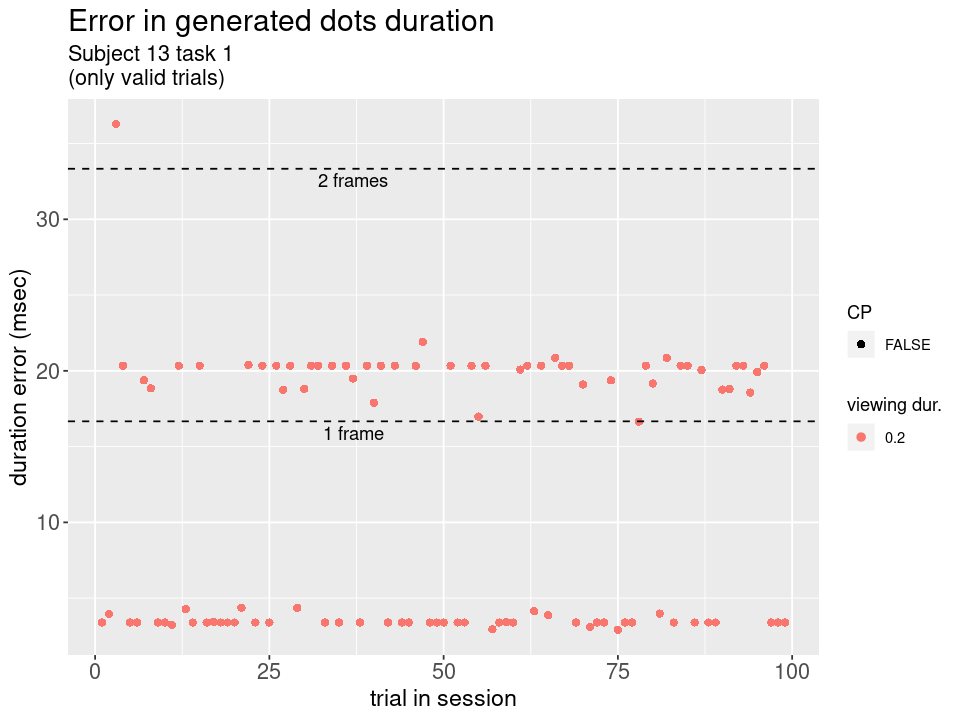

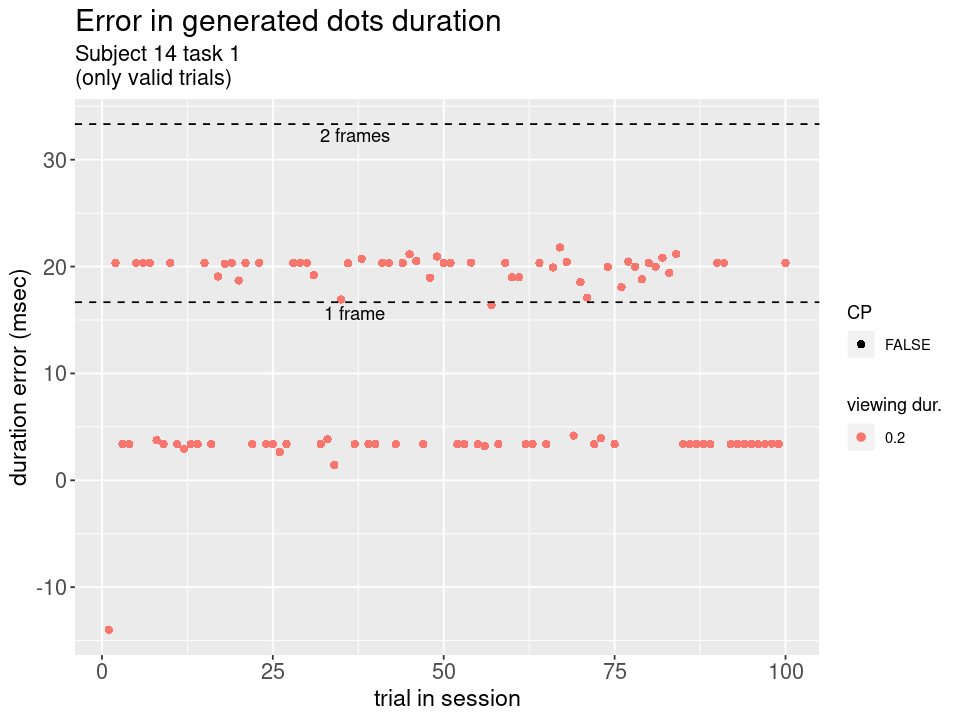

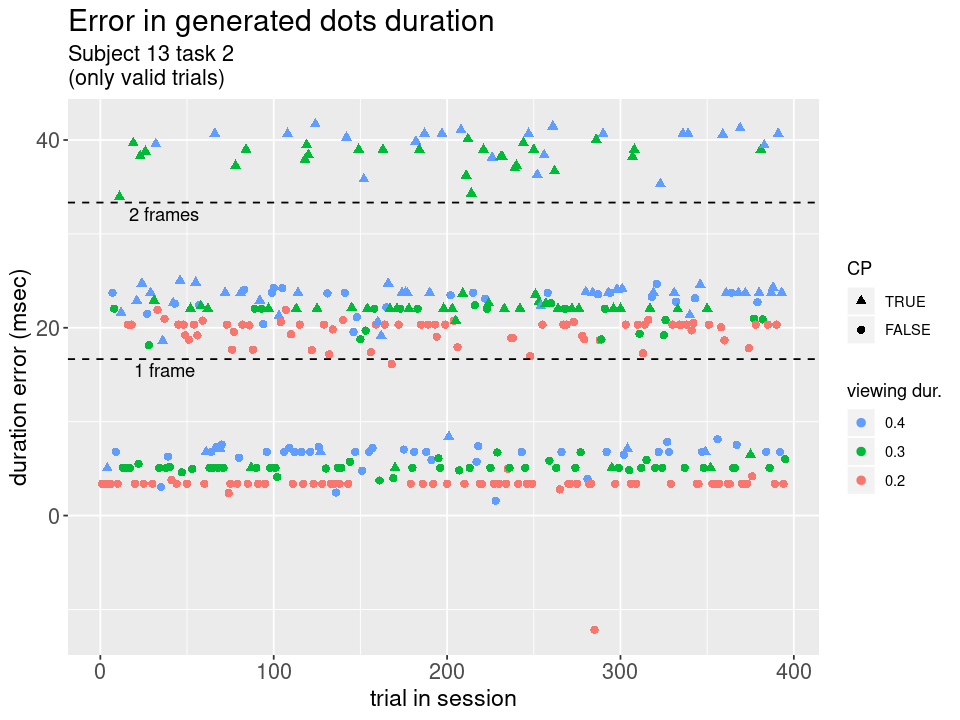

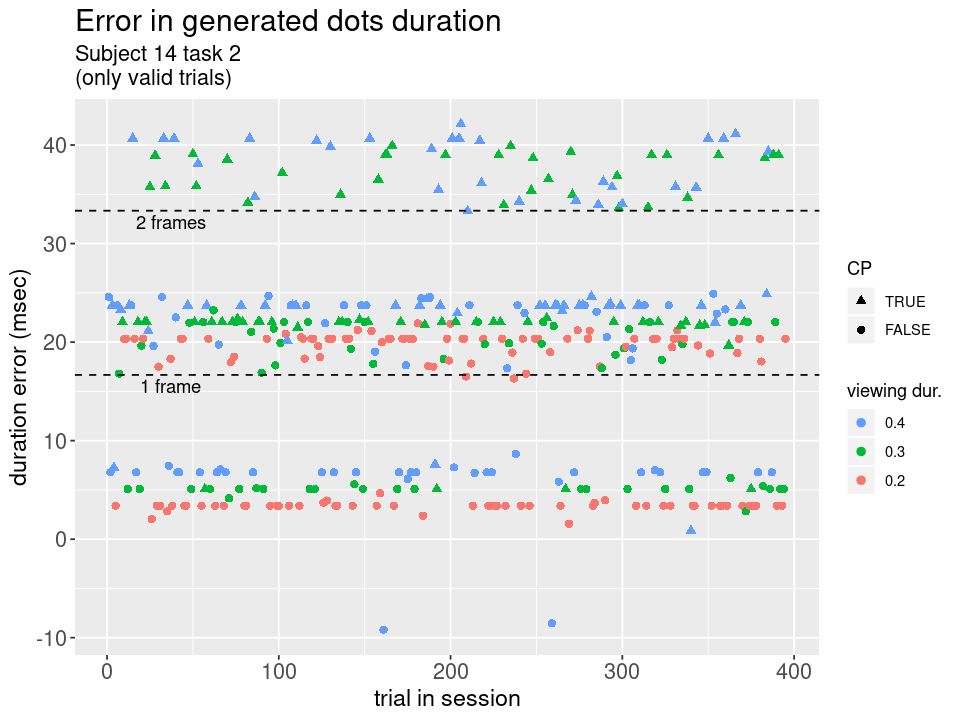

In [47]:
for (node in NODES) {
    for (subj in PILOT_NUMBERS) {
        durTable <- TRIALS[pilotID==subj & taskID==node & !is.na(validTrialCount),
                       .(dotsDurationError = (dotsOff - dotsOn - viewingDuration) * 1000, 
                       presenceCP, 
                       viewingDuration), 
                       by=validTrialCount]

        horizLines <- c(FRAME_DURATION*1000,FRAME_DURATION * 2000)

        # control output figure size
        options(repr.plot.width=8, repr.plot.height=6)

        # call to ggplot()
        g <- ggplot(durTable, aes(x=validTrialCount, y=dotsDurationError)) + 
            geom_point(aes(shape=presenceCP, col=factor(viewingDuration)),size=POINT_SIZE) +
            geom_hline(yintercept = horizLines, linetype="dashed") +
            annotate("text", x=37, y=horizLines, vjust = 1.3, label = c("1 frame","2 frames")) +
            labs(title="Error in generated dots duration", 
                 subtitle=paste("Subject",subj,"task",node,"\n(only valid trials)",sep=" "), 
                 y="duration error (msec)", 
                 x="trial in session",
                 colour="viewing dur.", shape="CP") + 
            guides(colour = guide_legend(reverse=T), shape=guide_legend(reverse=T)) +
            mytheme
        plot(g)
    }
}

The plot above shows that most real viewing durations are roughly 20 msec longer than the intended ones.
In a sizeable number of trials, the error rises to 40 msec, and this almost exclusively happens on change point trials.

Below I try to estimate the mean errors, clustered. 

In [ ]:
print("empty for now")
# intervals <- bin(durTable[,.(dotsDurationError)], nbins = 3, method = "cluster")
# names(intervals) <- "interval"

# # add the bins as a factor to the data.table
# durTable[, ("interval") := intervals]

# # compute mean durations
# unordered <- durTable[, .(num_trials=.N, meanDurationError = mean(dotsDurationError)), by = intervals]

# # display results, with num_frame column
# unordered[order(meanDurationError),.(num_trials, meanDurationError, num_frames = (meanDurationError * FRAME_RATE_ESTIMATE / 1000))]

# Accuracy analysis
<a id='acc'></a>
**NOTE:**
The actual analysis of the psychophysical data is performed in the notebook `psychophysics.ipynb`. Here, we merely perform quick visualization and _create the_ `psychophysical_data.csv` _dataset_ used in the aforementioned notebook.  
- Accuracy (% correct) on all trials with non-zero coherence

In [ ]:
accuracy <- TRIALS[coherence > 0 & !is.na(validTrialCount),sum(correct)/.N]
cat('accuracy on trials with non-zero coherence:', accuracy * 100,"%", sep = '')

## Psychometric curves
Recall that rightward motion corresponds to direction 0 degrees and choice 1.
Below, we set the coherence to its negative counterpart every time 
the direction of motion at the end of the trial is leftward (180 degrees).

In [ ]:
str(TRIALS)

In [ ]:
# create a specific column signedCoherence
TRIALS[, signedCoherence := coherence]
TRIALS[endDirection==180, signedCoherence := -coherence]
# set values to NA when there is a change point or when trial is not valid
TRIALS[presenceCP | is.na(validTrialCount), signedCoherence := NA_integer_]
# str(TRIALS)

**Here we dump a .csv file for psychophysical data analysis**

In [ ]:
pp_dump <- TRIALS[!is.na(validTrialCount)]

pp_dump[,choice:=droplevels(choice)]        # drop unused level "NA" for choice variable

# print(nrow(pp_dump[choice=="1"]))
levels(pp_dump$choice) <- c('left','right') # rename remaining levels
# print(nrow(pp_dump[choice=="right"]))

# treat presenceCP as factor and rename the labels
# print(nrow(pp_dump[presenceCP==TRUE]))
pp_dump[,presenceCP:=as.factor(presenceCP)]
# print(nrow(pp_dump[presenceCP=="TRUE"]))
levels(pp_dump$presenceCP) <- c('no','yes')
# print(nrow(pp_dump[presenceCP=="yes"]))

fwrite(pp_dump[,.(validTrialCount, 
               choice, 
               correct, 
               presenceCP, 
               viewingDuration, 
               signedCoherence, 
               coherence, 
               choice_time = choiceTime - dotsOff,
               exactVD = dotsOff - dotsOn)], file = "psychophysical_data.csv", na="NA")

In [ ]:
z <- 1.96 # For 95% confidence intervals
# create new data.table with columns "propChooseRight" and "se" (for standard error)
ppTable1 <- TRIALS[!is.na(validTrialCount), .(propChooseRight=sum(choice=="1")/.N, n=.N), by=signedCoherence]
ppTable1[,se:=sqrt(propChooseRight*(1-propChooseRight)/n)]
ppTable1[,ci:=z*se]

In [ ]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=5)
ggplot(ppTable1, aes(x=signedCoherence, y=propChooseRight)) +
    geom_errorbar(aes(ymin=propChooseRight-ci, ymax=propChooseRight+ci), width=ERROR_WIDTH) +
    geom_line() +
    geom_point() +
    ggtitle("Psychometric curve\nwith 95% confidence intervals") +
    theme(plot.title=element_text(size=20, lineheight=1.2),  # title
            plot.subtitle=element_text(size=15, family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

### Psychometric curves grouped by change-point condition
Let's compute the same curve, separating CP and non-CP trials

In [ ]:
ppTableCP <- TRIALS[!is.na(validTrialCount) & presenceCP==1, .(propChooseRightCP=sum(choice == "1")/.N, nCP=.N), by=signedCoherence]
ppTableCP[,seCP:=sqrt(propChooseRightCP*(1-propChooseRightCP)/nCP)]
ppTableNonCP <- TRIALS[!is.na(validTrialCount) & presenceCP==0, .(propChooseRightNonCP=sum(choice == "1")/.N, nNonCP=.N), by=signedCoherence]
ppTableNonCP[,seNonCP:=sqrt(propChooseRightNonCP*(1-propChooseRightNonCP)/nNonCP)]

In [ ]:
# merge the two tables and put them in long format
setkey(ppTableCP, signedCoherence)
setkey(ppTableNonCP, signedCoherence)

# Full OUTER JOIN (see https://rstudio-pubs-static.s3.amazonaws.com/52230_5ae0d25125b544caab32f75f0360e775.html)
psychophys <- merge(ppTableCP,ppTableNonCP,all=TRUE)

# convert to long format
longPsychophys <- melt(psychophys, 
                    id.vars=c("signedCoherence","seCP","seNonCP"),
                    measure.vars=c("propChooseRightCP","propChooseRightNonCP"),
                    variable.name="CPcategory", value.name="propChooseRight")

# add se col
longPsychophys[,se:=seCP]
longPsychophys[CPcategory=='propChooseRightNonCP', se:=seNonCP]
longPsychophys[,ci:=z*se]

# head(psychophys)
# head(longPsychophys)

In [ ]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=5)

# ref on error bars
# http://www.cookbook-r.com/Graphs/Plotting_means_and_error_bars_(ggplot2)/

pd <- position_dodge(1.5)
# ggplot(longPsychophys, aes(x=signedCoherence, y=propChooseRight)) +
#     geom_errorbar(aes(ymin=propChooseRight-ci, ymax=propChooseRight+ci, col=CPcategory), width=.1, position=pd) +
#     geom_line(aes(col=CPcategory),position=pd) +
#     geom_point(aes(col=CPcategory),position=pd)

ggplot(longPsychophys, aes(x=signedCoherence, y=propChooseRight, colour=CPcategory, group=CPcategory)) + 
    geom_errorbar(aes(ymin=propChooseRight-ci, ymax=propChooseRight+ci), colour="black", width=ERROR_WIDTH, position=pd) +
    geom_line(position=pd, size=LINE_WIDTH) +
    geom_point(position=pd, size=3, shape=21, fill="white") + # 21 is filled circle
    xlab("% coherence (+- for direction)") +
    ylab("Proportion Choose Right") +
    scale_colour_hue(name="Trial type",    # Legend label, use darker colors
                     breaks=c("propChooseRightCP", "propChooseRightNonCP"),
                     labels=c("CP", "No CP"),
                     l=40) +                    # Use darker colors, lightness=40
    ggtitle("Psychometric curves grouped by CP presence\nwith 95% confidence intervals") +
    expand_limits(y=0) +                        # Expand y range
    scale_y_continuous(breaks=c(0,.25,0.5,0.75,1)) +         # Set tick every 4
    theme_bw() +
    theme(plot.title=element_text(size=20, lineheight=1.2),  # title
          plot.subtitle=element_text(size=15, family="American Typewriter"),  # subtitle
          plot.caption=element_text(size=15),  # caption
          axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
          axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
          axis.text.x=element_text(size=AXES_FONT),  # X axis text
          axis.text.y=element_text(size=AXES_FONT),  # Y axis text
          legend.justification=c(1,0),
          legend.position=c(1,0))               # Position legend in bottom right

## Accuracy as a function of viewing duration

In [ ]:
# first get marginal frequencies
toDisplay <- TRIALS[!is.na(validTrialCount) & coherence > 0,.(freq = .N, correct = sum(correct)), by=viewingDuration]

# then add the accuracy column
toDisplay[,accuracy := correct/freq]
toDisplay[,se := sqrt(accuracy * (1-accuracy)/ freq)]

# head(toDisplay)

pd <- position_dodge(0)
ggplot(toDisplay, aes(x=viewingDuration, y=accuracy)) +
    geom_errorbar(aes(ymin=accuracy-z*se, ymax=accuracy+z*se), width=0.03, position=pd) +
    geom_line(position=pd) +
    geom_point(position=pd) +
    ggtitle("Percent correct on non-zero coherence trials\n 95% confidence intervals") +
    theme(plot.title=element_text(size=20, lineheight=1.2),  # title
            plot.subtitle=element_text(size=15, family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

### Grouped by change-point condition
And now separating according to change point trials:

In [ ]:
# first get marginal frequencies
accDuration <- TRIALS[!is.na(validTrialCount) & coherence > 0,.(freq = .N, correct = sum(correct)), by=.(viewingDuration,presenceCP)]


# then add the accuracy column
accDuration[,accuracy := correct/freq]

# head(accDuration)

# # conver to long format
# longAccDuration <- melt(accDuration, 
#                     id.vars=c("viewingDuration"),
#                     measure.vars=c("accuracy"),
#                     variable.name="CPcategory", value.name="accuracy")

# head(longAccDuration)

# add standard error column
accDuration[,se := sqrt(accuracy * (1-accuracy)/ freq)]

# set presenceCP to factor variable
accDuration[,presenceCP := as.factor(presenceCP)]

# head(toDisplay)

# control output figure size
options(repr.plot.width=8, repr.plot.height=7)

pd <- position_dodge(.01)

ggplot(accDuration, aes(x=viewingDuration, y=accuracy, colour=presenceCP, group=presenceCP)) + 
    geom_errorbar(aes(ymin=accuracy-z*se, ymax=accuracy+z*se), width=SMALL_ERROR_WIDTH, colour="black", position=pd) +
    geom_line(position=pd, size=LINE_WIDTH) +
    geom_point(position=pd, size=3, shape=21, fill="white") + # 21 is filled circle
    xlab("viewing duration (sec)") +
    ylab("Percent Correct") +
    scale_colour_hue(name="CP presence",    # Legend label, use darker colors
#                      breaks=c("propChooseRightCP", "propChooseRightNonCP"),
#                      labels=c("CP", "No CP"),
                     l=40) +                    # Use darker colors, lightness=40
    ggtitle("Accuracy as function of viewing duration\nwith 95% confidence intervals (and 0%-coh excluded)") +
    expand_limits(y=c(0.5,1)) +                        # Expand y range
    scale_y_continuous(breaks=c(0.5,0.75,1)) +         # Set tick every 4
    theme_bw() +
    theme(plot.title=element_text(size=20, lineheight=1.2),  # title
          plot.subtitle=element_text(size=15, family="American Typewriter"),  # subtitle
          plot.caption=element_text(size=15),  # caption
          axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
          axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
          axis.text.x=element_text(size=AXES_FONT),  # X axis text
          axis.text.y=element_text(size=AXES_FONT),  # Y axis text
          legend.justification=c(1,0),
          legend.position=c(1,0))               # Position legend in bottom right
  

## Accuracy as a function of coherence level

In [ ]:
# first get marginal frequencies
accCoh <- TRIALS[!is.na(validTrialCount),.(freq = .N, correct = sum(correct)), by=coherence]

# then add the accuracy column
accCoh[,accuracy := correct/freq]
accCoh[,se := sqrt(accuracy * (1-accuracy)/ freq)]
# deal with coh=0 artificially
accCoh[coherence==0, accuracy:=0.5]
accCoh[coherence==0, se:=0]

# control output figure size
options(repr.plot.width=8, repr.plot.height=5)

# pd <- position_dodge(0)
ggplot(accCoh, aes(x=coherence, y=accuracy)) +
    geom_errorbar(aes(ymin=accuracy-z*se, ymax=accuracy+z*se), width=ERROR_WIDTH) +
    geom_line(size=.8*LINE_WIDTH) +
    geom_point(size=1.6*POINT_SIZE, fill="white", shape=21) +
    ggtitle("Percent correct as a function of coherence\n 95% confidence intervals") +
    theme(plot.title=element_text(size=20, lineheight=1.2),  # title
            plot.subtitle=element_text(size=15, family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

# Autocorrelation of choices
<a id='autocorr'></a>

In [ ]:
# control output figure size
options(repr.plot.width=6, repr.plot.height=4)

acf(TRIALS[!is.na(validTrialCount), choice, by=validTrialCount]$choice)

And of trials' `endDirection`.

In [ ]:
acf(TRIALS[!is.na(validTrialCount), endDirection, by=validTrialCount]$endDirection)

# Dot count in hemifields for 0-coherence trials
<a id='dotcount'></a>

I wonder whether the difference between the number of dots in the right and left halves of the stimulus aperture predicts subject's responses on 0-coherence trials.

In [ ]:
zeroCohTrials <- TRIALS[!is.na(validTrialCount) & coherence == 0, .(choice, viewingDuration), by=validTrialCount]
setkey(zeroCohTrials, validTrialCount)
setkey(DOTS, validTrialCount)

# inner join syntax
zeroCohDots <- zeroCohTrials[DOTS, nomatch=0]
# nrow(zeroCohTrials)
# nrow(zeroCohDots[,.N,by=trialCount])

# add boolean columns to flag hemifield location of dots
zeroCohDots[,`:=`(rightDots = xpos>=0.5 & isActive, leftDots = xpos < 0.5 & isActive)]
diffDots <- zeroCohDots[,diffDots:=sum(rightDots)-sum(leftDots), by=trialCount]


# control output figure size
options(repr.plot.width=8, repr.plot.height=5)

ggplot(diffDots, aes(x=trialCount, y=diffDots)) +
    geom_point(aes(shape=factor(choice))) + 
    facet_wrap( ~ viewingDuration) + 
    guides(shape = guide_legend(reverse=T)) +
    labs(shape="choice")

In [ ]:
# control output figure size
options(repr.plot.width=5, repr.plot.height=3)

print("Should I use lm or a Spearman rank correlation test instead?")
#refs on Spearman rank correlation test
# http://www.biostathandbook.com/spearman.html
# http://rcompanion.org/rcompanion/e_02.html
# summary(lm(diffDots ~ factor(choice), diffDots))

ggplot(diffDots, aes(x=choice, y=diffDots)) +
    geom_point() 

# Miscellaneous
##  Explore random seed

In [ ]:
seedTable <- TRIALS[!is.na(validTrialCount),.(randSeedBase),by=validTrialCount]

# control output figure size
options(repr.plot.width=7, repr.plot.height=6)

g <- ggplot(seedTable, aes(x=validTrialCount, y=randSeedBase)) + 
  geom_line(size=.2) #+  geom_point(aes(shape=factor(presenceCP), col=factor(viewingDuration)),size=3) 

# Add Title and Labels
g + labs(title="Random seed base", 
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""), 
         y="randSeedBase", 
         x="trial (in session order)") + theme(plot.title=element_text(size=20, 
                                    color="tomato",
                                    lineheight=1.2),  # title
            plot.subtitle=element_text(size=15),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text